## Imports and Loads

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from importlib import reload
import src.utils.utils
reload(src.utils.utils)
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

from src.utils.utils import compute_MSE_R2score, plot_feature_importance, plot_importance_per_period

In [2]:
data_folder = './data/'
pickle_folder = data_folder + 'pickle/'
imdb_folder = data_folder + 'IMDB/'
cmu_folder = data_folder + 'CMU/'

with open(pickle_folder + 'movies_clean.p', 'rb') as f:
    movie_data = pickle.load(f)

In [3]:
movie_data

,Wikipedia_movie_ID,Movie_name,Movie_box_office_revenue,Year,Year_Interval,nb_of_Genres,Genre_Action,Genre_Adventure,Genre_Animated,Genre_Black-and-white,...,Country_Germany,Country_Hong Kong,Country_India,Country_Italy,Country_Japan,Country_Other,Country_United Kingdom,Country_United States of America,averageRating,numVotes
0,3217,Army of Darkness,21502796.0,1992,1970-2000,12,True,True,True,False,...,False,False,False,False,False,False,False,True,7.4,197717.0
1,3333,The Birth of a Nation,50000000.0,1915,1915-1930,7,False,False,False,True,...,False,False,False,False,False,False,False,True,6.1,26681.0
2,3746,Blade Runner,33139618.0,1982,1970-2000,12,False,False,False,False,...,False,True,False,False,False,False,False,True,8.1,835060.0
3,3837,Blazing Saddles,119500000.0,1974,1970-2000,3,False,False,False,False,...,False,False,False,False,False,False,False,True,7.7,155432.0
4,3947,Blue Velvet,8551228.0,1986,1970-2000,3,False,False,False,False,...,False,False,False,False,False,False,False,True,7.7,219742.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34784,36674310,Mystery of Marie Roget,NaN,1942,1930-1950,1,False,False,False,False,...,False,False,False,False,False,False,False,True,5.9,371.0
34785,36683360,2016: Obama's America,33449086.0,2012,2000-2015,1,False,False,False,False,...,False,False,False,False,False,False,False,True,4.8,11049.0
34786,36814246,Eraserhead,7000000.0,1977,1970-2000,10,False,True,False,True,...,False,False,False,False,False,False,False,True,7.3,130107.0
34788,36929245,Before Midnight,NaN,2013,2000-2015,2,False,False,False,False,...,False,False,False,False,False,False,False,True,7.9,175072.0


## Data Preprocessing

In this section, we will prepare the data for modeling.

In [4]:
df_mod = movie_data.copy()

In [5]:
df_mod.columns.to_list()

['Wikipedia_movie_ID',
 'Movie_name',
 'Movie_box_office_revenue',
 'Year',
 'Year_Interval',
 'nb_of_Genres',
 'Genre_Action',
 'Genre_Adventure',
 'Genre_Animated',
 'Genre_Black-and-white',
 'Genre_Bollywood',
 'Genre_Chinese Movies',
 'Genre_Comedy',
 'Genre_Crime',
 'Genre_Disaster',
 'Genre_Documentary',
 'Genre_Drama',
 'Genre_Experimental',
 'Genre_Fantasy',
 'Genre_Historical',
 'Genre_Horror',
 'Genre_Japanese Movies',
 'Genre_Musical',
 'Genre_Noir',
 'Genre_Pornographic',
 'Genre_Propaganda',
 'Genre_Romance',
 'Genre_Science Fiction',
 'Genre_Silent film',
 'Genre_Sports',
 'Genre_Teen',
 'Genre_Thriller',
 'Genre_War',
 'Genre_Western',
 'Genre_World cinema',
 'nb_of_Languages',
 'lang_english',
 'lang_french',
 'lang_german',
 'lang_hindi',
 'lang_italian',
 'lang_japanese',
 'lang_other',
 'lang_silent film',
 'lang_spanish',
 'lang_standard mandarin',
 'lang_tamil',
 'nb_of_Countries',
 'Country_Argentina',
 'Country_Canada',
 'Country_France',
 'Country_Germany',
 'Co

In [6]:
# Droping columns that are not needed for the modeling process
df_mod.drop(columns=['Movie_name', 'Wikipedia_movie_ID'], inplace=True)

In [7]:
df_mod.dtypes

Movie_box_office_revenue            float64
Year                                  int64
Year_Interval                        object
nb_of_Genres                          int64
Genre_Action                           bool
Genre_Adventure                        bool
Genre_Animated                         bool
Genre_Black-and-white                  bool
Genre_Bollywood                        bool
Genre_Chinese Movies                   bool
Genre_Comedy                           bool
Genre_Crime                            bool
Genre_Disaster                         bool
Genre_Documentary                      bool
Genre_Drama                            bool
Genre_Experimental                     bool
Genre_Fantasy                          bool
Genre_Historical                       bool
Genre_Horror                           bool
Genre_Japanese Movies                  bool
Genre_Musical                          bool
Genre_Noir                             bool
Genre_Pornographic              

# Correlation Analysis

In this section, we will analyze the correlation matrix and use it to plot the correlation between the features and the average rating variable.

In [8]:
df_corr = df_mod.copy()

In [9]:
df_corr.shape

(25184, 59)

In [10]:
df_corr[df_corr.isnull().any(axis=1)]

,Movie_box_office_revenue,Year,Year_Interval,nb_of_Genres,Genre_Action,Genre_Adventure,Genre_Animated,Genre_Black-and-white,Genre_Bollywood,Genre_Chinese Movies,...,Country_Germany,Country_Hong Kong,Country_India,Country_Italy,Country_Japan,Country_Other,Country_United Kingdom,Country_United States of America,averageRating,numVotes
15,NaN,1939,1930-1950,4,True,False,False,True,False,False,...,False,False,False,False,False,False,False,True,7.6,12765.0
20,NaN,1937,1930-1950,4,False,False,False,True,False,False,...,False,False,False,False,False,True,True,False,6.8,11106.0
23,NaN,1973,1970-2000,4,True,False,False,False,False,False,...,False,True,False,False,False,False,False,True,7.6,114487.0
28,NaN,1998,1970-2000,12,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,7.5,56028.0
30,NaN,1962,1950-1970,7,False,True,False,False,False,False,...,False,False,False,False,True,False,False,False,6.2,2242.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34781,NaN,2012,2000-2015,3,False,False,False,False,False,False,...,False,False,False,False,False,True,True,False,8.2,73628.0
34782,NaN,1939,1930-1950,3,True,False,False,False,False,False,...,False,False,False,False,False,False,False,True,5.7,271.0
34784,NaN,1942,1930-1950,1,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,5.9,371.0
34788,NaN,2013,2000-2015,2,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,7.9,175072.0


We drop the column "Movie_box_office_revenue" since it has 73% missing values:


In [11]:
df_corr.drop(columns=['Movie_box_office_revenue'], inplace=True)

In [12]:
df_corr[df_corr.isnull().any(axis=1)]

,Year,Year_Interval,nb_of_Genres,Genre_Action,Genre_Adventure,Genre_Animated,Genre_Black-and-white,Genre_Bollywood,Genre_Chinese Movies,Genre_Comedy,...,Country_Germany,Country_Hong Kong,Country_India,Country_Italy,Country_Japan,Country_Other,Country_United Kingdom,Country_United States of America,averageRating,numVotes


In [13]:
df_corr.dtypes

Year                                  int64
Year_Interval                        object
nb_of_Genres                          int64
Genre_Action                           bool
Genre_Adventure                        bool
Genre_Animated                         bool
Genre_Black-and-white                  bool
Genre_Bollywood                        bool
Genre_Chinese Movies                   bool
Genre_Comedy                           bool
Genre_Crime                            bool
Genre_Disaster                         bool
Genre_Documentary                      bool
Genre_Drama                            bool
Genre_Experimental                     bool
Genre_Fantasy                          bool
Genre_Historical                       bool
Genre_Horror                           bool
Genre_Japanese Movies                  bool
Genre_Musical                          bool
Genre_Noir                             bool
Genre_Pornographic                     bool
Genre_Propaganda                

In [14]:
# Convert the Year_interval column to a categorical column
categorical_columns = ['Year_Interval']
other_columns = [col for col in df_corr.columns if col not in categorical_columns]
features = pd.get_dummies(df_corr[categorical_columns])
df_corr_encoded = pd.concat([df_corr[other_columns], features], axis=1)
df_corr_encoded.dtypes

Year                       int64
nb_of_Genres               int64
Genre_Action                bool
Genre_Adventure             bool
Genre_Animated              bool
                           ...  
Year_Interval_1915-1930     bool
Year_Interval_1930-1950     bool
Year_Interval_1950-1970     bool
Year_Interval_1970-2000     bool
Year_Interval_2000-2015     bool
Length: 62, dtype: object

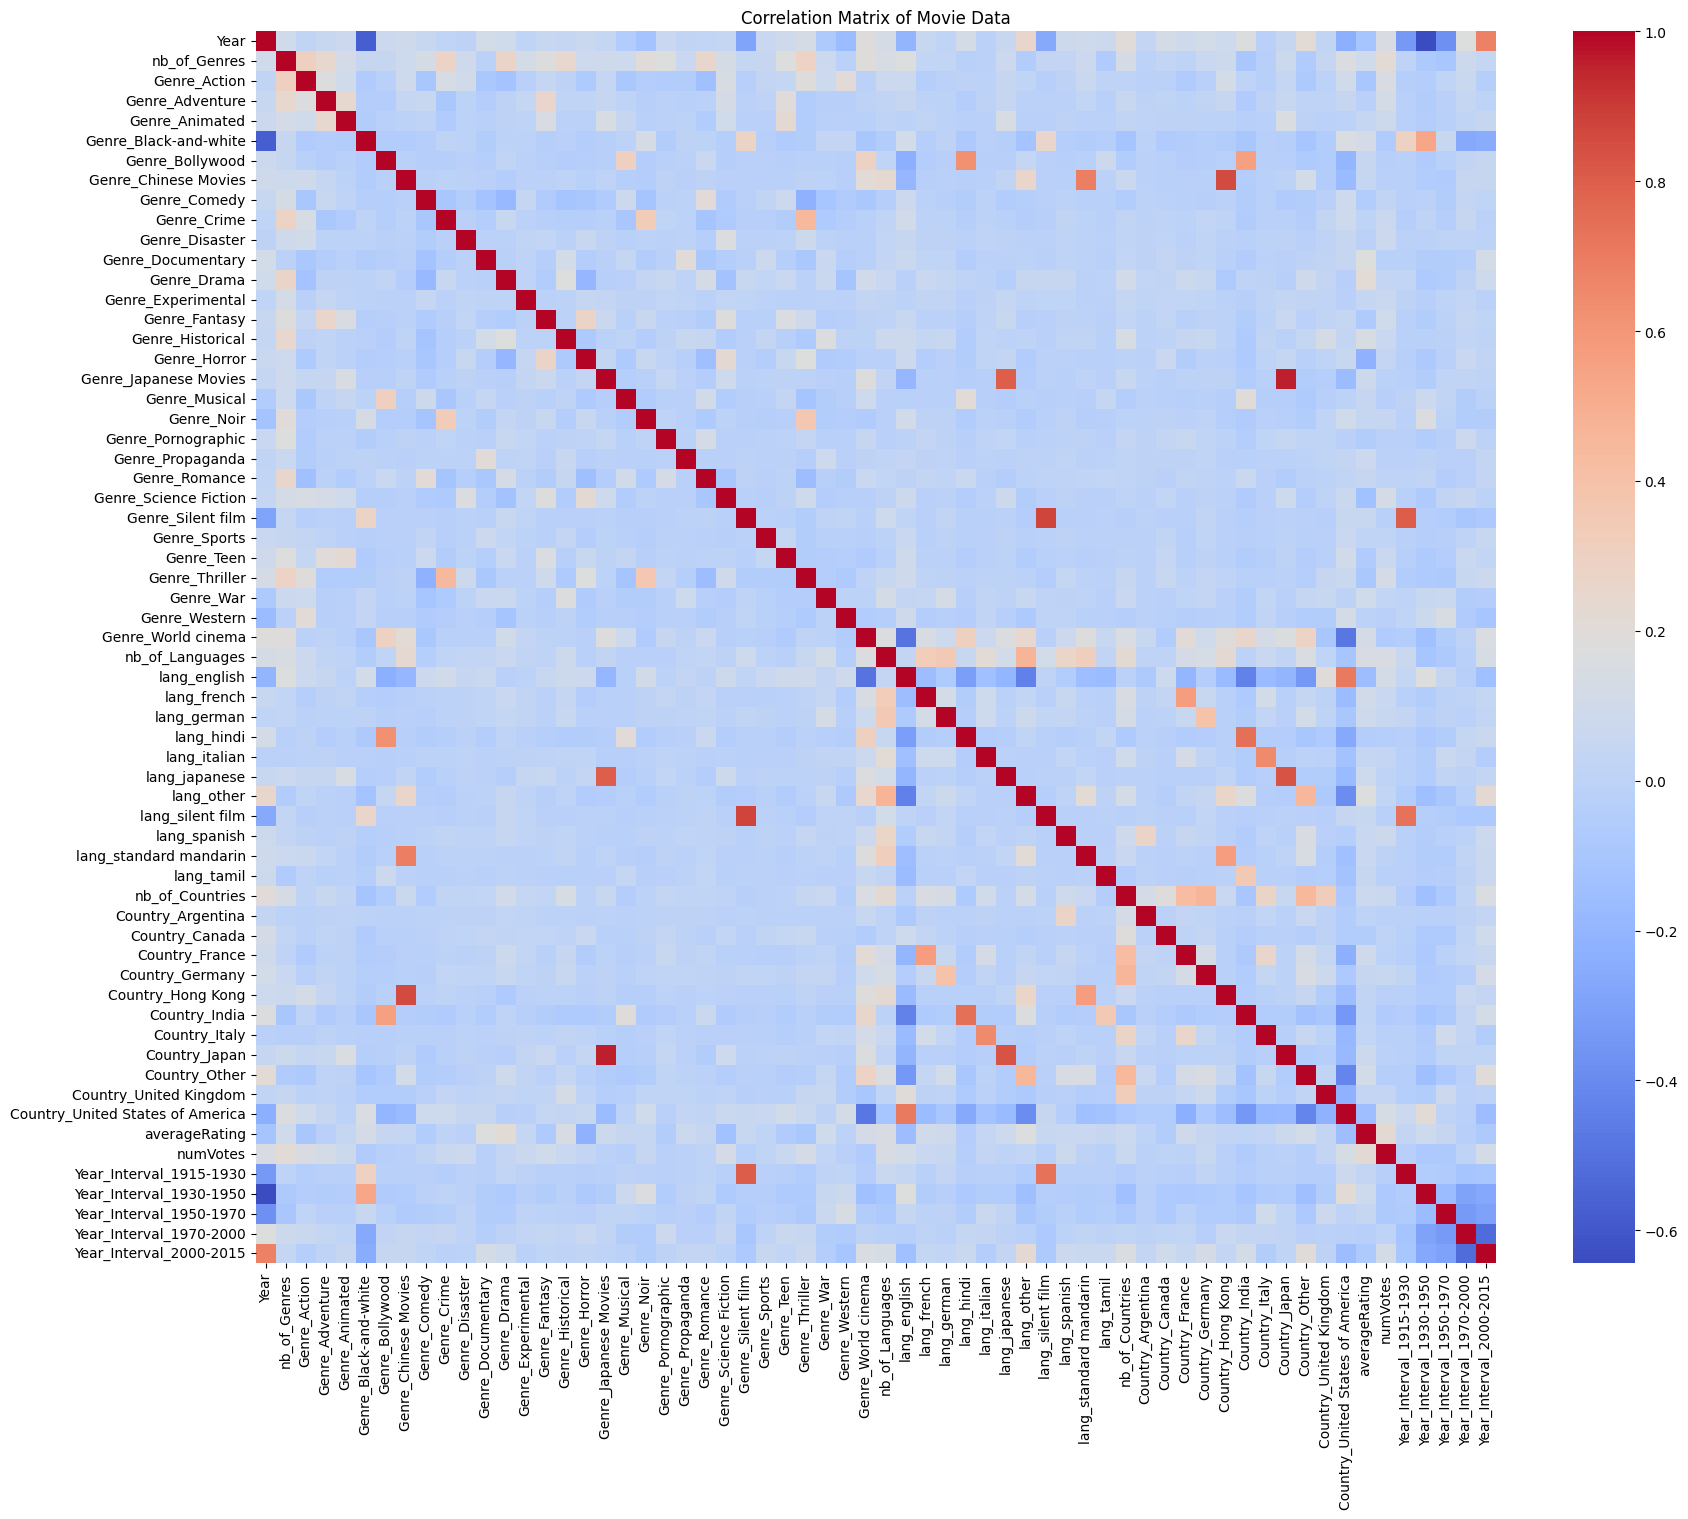

In [15]:
# Perform correlation analysis
correlation_matrix = df_corr_encoded.corr()
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Movie Data')
plt.show()

The features do not show significant correlations, except for logically related ones, such as the country Japan and the genre Japanese movies.

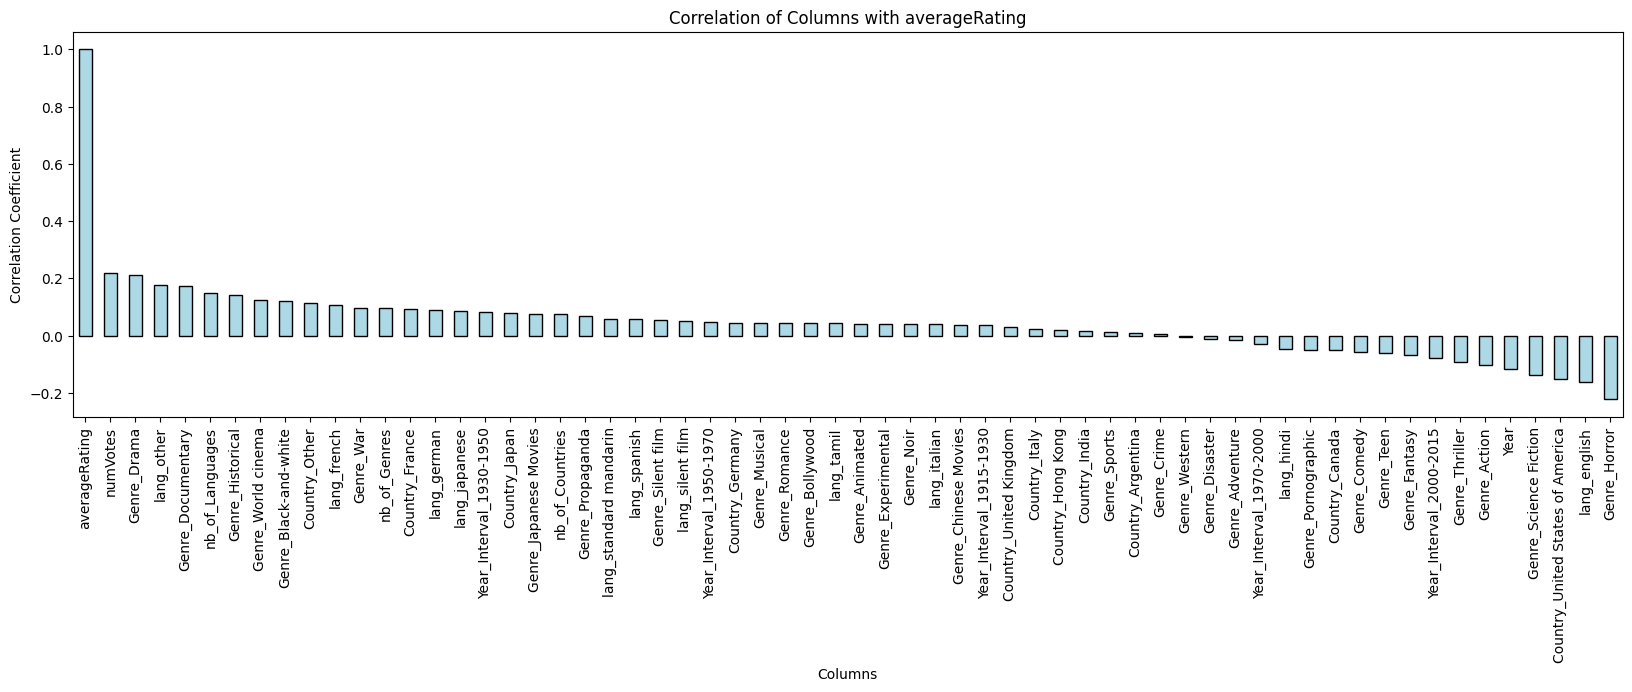

In [16]:
# Calculate the correlation of each column with the target category 'averageRating'
correlation_with_target = correlation_matrix['averageRating'].sort_values(ascending=False)

# Plot the bar chart
plt.figure(figsize=(20, 5))
correlation_with_target.plot(kind='bar', color= 'lightblue', edgecolor='black')
plt.title('Correlation of Columns with averageRating')
plt.xlabel('Columns')
plt.ylabel('Correlation Coefficient')
plt.show()

# Modeling and Feature Importance

In this section, we will train various regression models to predict the average rating and the box office revenue of movies. The models we will evaluate include:

- Linear Regression
- Ridge Regression
- Random Forest
- XGBoost
- Bagging Regressor
- Gradient Boosting
- Decision Tree

We will use the Mean Squared Error (MSE), the R-squared score and the Mean Absolute error (MAE) to compare the performance of these models. We will take the best model to evaluate the importance and impact of each feature on the average rating and box office revenue.

## 1. Average Rating Prediction

### Models Training

In [17]:
df_mod['averageRating'].describe()

count    25184.000000
mean         6.278629
std          1.042755
min          1.100000
25%          5.700000
50%          6.400000
75%          7.000000
max          9.300000
Name: averageRating, dtype: float64

In [18]:
# Define features and target
X_av = df_mod.drop(columns=['Movie_box_office_revenue','averageRating', 'Year_Interval'])
y_av = df_mod['averageRating']

# Split data
X_train_av, X_test_av, y_train_av, y_test_av = train_test_split(X_av, y_av, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled_av = scaler.fit_transform(X_train_av)
X_test_scaled_av = scaler.fit_transform(X_test_av)

In [19]:
# Train a Linear regression model
lr = LinearRegression()
mse_lr, r2_lr, _ = compute_MSE_R2score(lr,X_train_scaled_av,X_test_scaled_av,y_train_av,y_test_av)

# Train and predict a Ridge regression model
ridge = Ridge(alpha=1.0)
mse_ridge, r2_ridge, _ = compute_MSE_R2score(ridge,X_train_scaled_av,X_test_scaled_av,y_train_av,y_test_av)

# Train and predict a Random Forest model
rf = RandomForestRegressor(random_state=42)
mse_rf, r2_rf, _ = compute_MSE_R2score(rf,X_train_av,X_test_av,y_train_av,y_test_av)

# Train an XGBoost model
xgb = XGBRegressor(random_state=42)
mse_xgb, r2_xgb, _ = compute_MSE_R2score(xgb,X_train_av,X_test_av,y_train_av,y_test_av)

# Train a Bagging Regressor model
bag = BaggingRegressor(random_state=42)
mse_bag, r2_bag, _ = compute_MSE_R2score(bag,X_train_av,X_test_av,y_train_av,y_test_av)

# Train a Gradient Boosting model
gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
mse_gb, r2_gb, _ = compute_MSE_R2score(gb,X_train_av,X_test_av,y_train_av,y_test_av)

# Train a Decision Tree model
dt = DecisionTreeRegressor(random_state=42)
mse_dt, r2_dt, _ = compute_MSE_R2score(dt,X_train_av,X_test_av,y_train_av,y_test_av)


LinearRegression RMSE:  0.8473333389914199
LinearRegression R2:  0.34740464196344834
LinearRegression Mean Absolute Error:  0.6438592981928338

Ridge RMSE:  0.8473339417774245
Ridge R2:  0.34740371346112153
Ridge Mean Absolute Error:  0.643859985981552

RandomForestRegressor RMSE:  0.7029539480898488
RandomForestRegressor R2:  0.5508523410314085
RandomForestRegressor Mean Absolute Error:  0.5102154457018067

XGBRegressor RMSE:  0.6914933818292127
XGBRegressor R2:  0.5653782588562749
XGBRegressor Mean Absolute Error:  0.4990885472425468

BaggingRegressor RMSE:  0.7347161236900718
BaggingRegressor R2:  0.5093469159576317
BaggingRegressor Mean Absolute Error:  0.5340480444709153

GradientBoostingRegressor RMSE:  0.7196362336299035
GradientBoostingRegressor R2:  0.5292813176800754
GradientBoostingRegressor Mean Absolute Error:  0.5290622815358881

DecisionTreeRegressor RMSE:  0.9726192407171178
DecisionTreeRegressor R2:  0.14015314942378976
DecisionTreeRegressor Mean Absolute Error:  0.69

### Comparison of Model Performance: Mean Squared Error and R-squared

In [20]:
models = ['Linear Regression', 'Ridge Regression', 'Random Forest', 'XGBoost', 'Bagging Regressor', 
          'Gradient Boosting', 'Decision Tree']

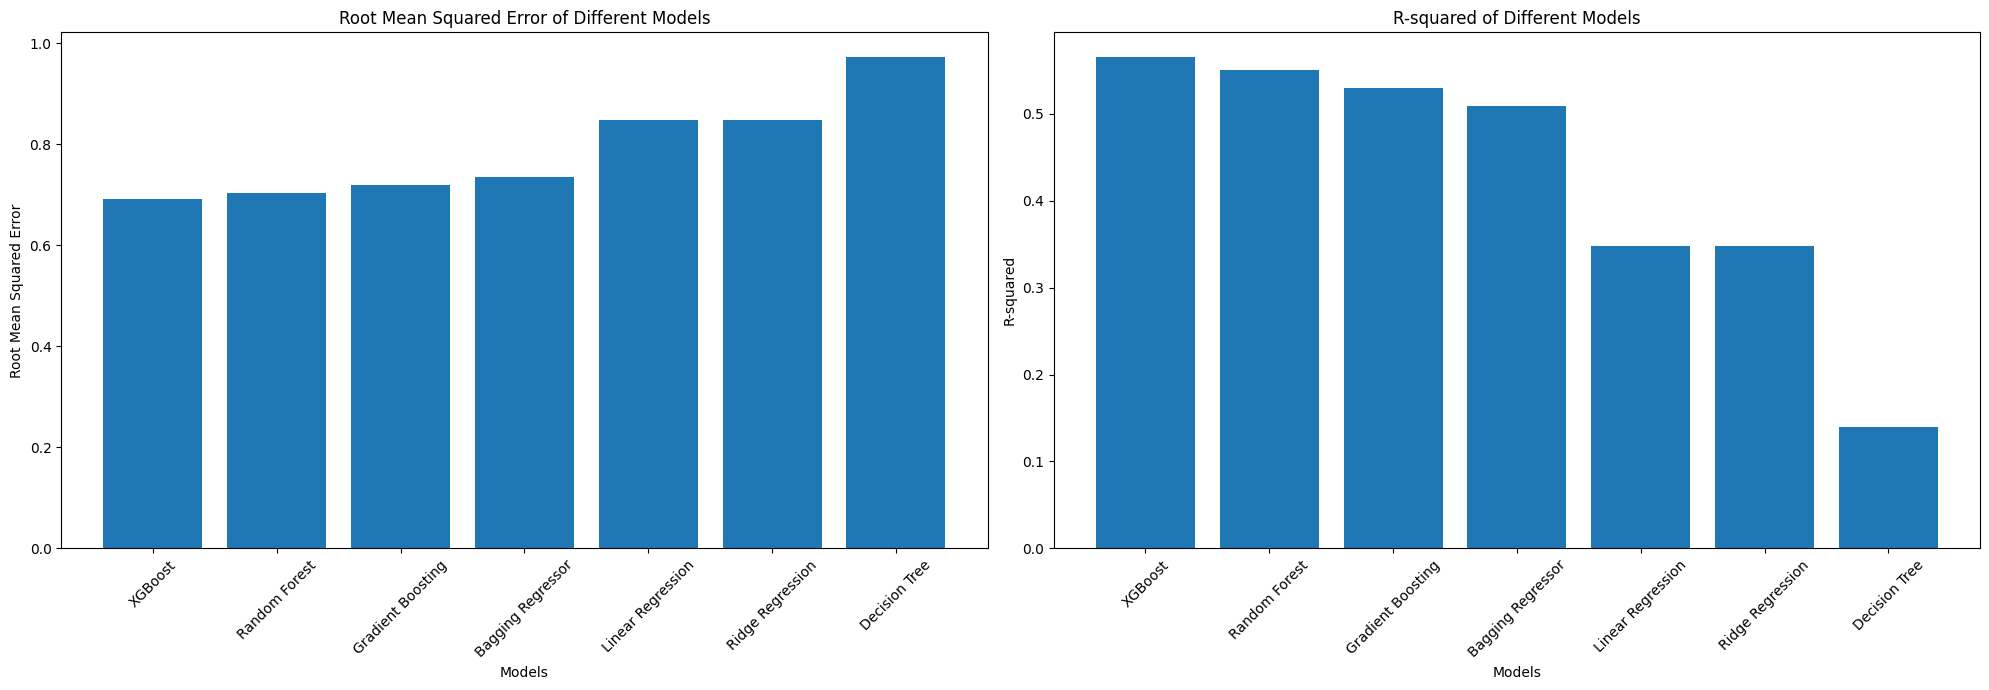

In [21]:
# Sorting the models 
errors_mse = [mse_lr, mse_ridge, mse_rf, mse_xgb, mse_bag, mse_gb, mse_dt]
sorted_pairs_mse = sorted(zip(errors_mse, models))
sorted_errors_mse, sorted_models = zip(*sorted_pairs_mse)

r2_scores = [r2_lr, r2_ridge, r2_rf, r2_xgb, r2_bag, r2_gb, r2_dt]
sorted_pairs_r2 = sorted(zip(r2_scores, models), reverse=True)
sorted_r2_scores, sorted_models_r2 = zip(*sorted_pairs_r2)


fig, ax = plt.subplots(1, 2, figsize=(20, 7))

# Plotting the Root Mean Squared Error of different models
ax[0].bar(sorted_models, sorted_errors_mse)
ax[0].set_xlabel('Models')
ax[0].set_ylabel('Root Mean Squared Error')
ax[0].set_title('Root Mean Squared Error of Different Models')
ax[0].tick_params(axis='x', rotation=45)

# Plotting the R-squared of different models
ax[1].bar(sorted_models_r2, sorted_r2_scores)
ax[1].set_xlabel('Models')
ax[1].set_ylabel('R-squared')
ax[1].set_title('R-squared of Different Models')
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

From the RMSE values, we can see that XGBoost has the lowest RMSE value, indicating better performance in terms of prediction accuracy. The R-squared scores also indicate that XGBoost has the highest R-squared value, suggesting that thia model explains a higher proportion of the variance in the average rating. 

Therefore, XGBoost seems to be the best model to predict the average rating of a movie. We will then use it to evaluate the importance and impact of each feature on the average rating.

### Feature Importance of the best model

#### A. Period 1915-2015

In [1]:
plot_feature_importance(xgb,X_av)

NameError: name 'plot_feature_importance' is not defined

#### B. Period per Interval

Analyzing period: 1970-2000

XGBRegressor RMSE:  0.7225509261511934
XGBRegressor R2:  0.5498059505428814
XGBRegressor Mean Absolute Error:  0.5353432778030924


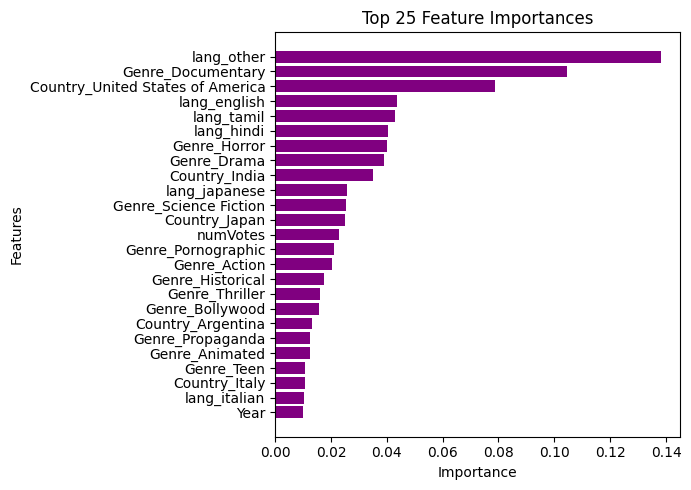

Analyzing period: 1915-1930

XGBRegressor RMSE:  0.5838819119067559
XGBRegressor R2:  0.3433509405638633
XGBRegressor Mean Absolute Error:  0.4525263296354801


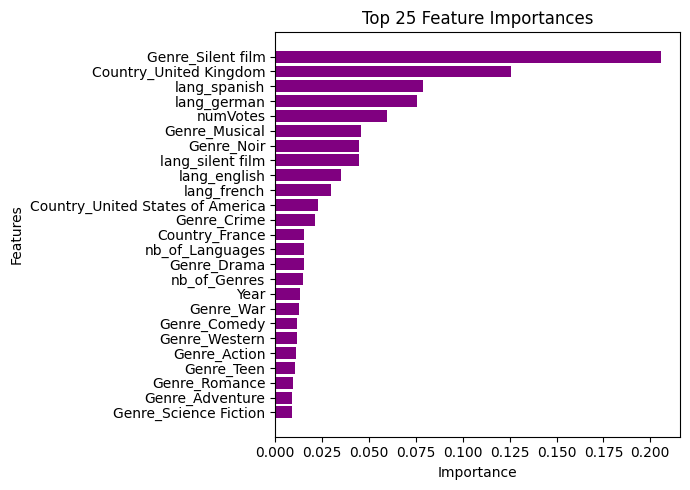

Analyzing period: 1930-1950

XGBRegressor RMSE:  0.48659578840406564
XGBRegressor R2:  0.5557073393985686
XGBRegressor Mean Absolute Error:  0.3596999257620127


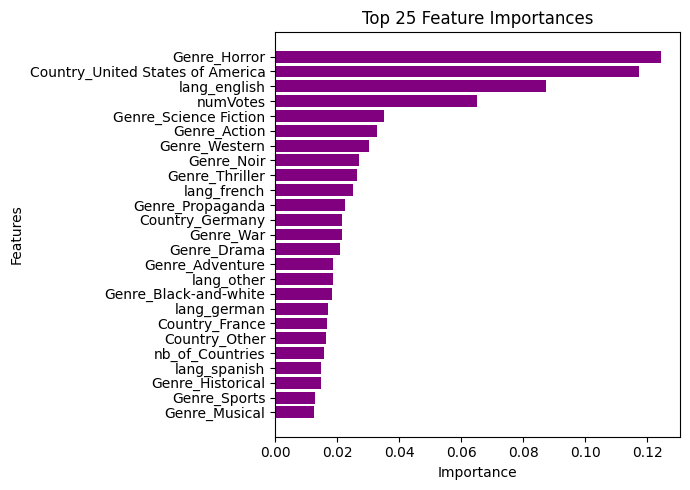

Analyzing period: 1950-1970

XGBRegressor RMSE:  0.6518433061521752
XGBRegressor R2:  0.5171541847637555
XGBRegressor Mean Absolute Error:  0.4641523514368305


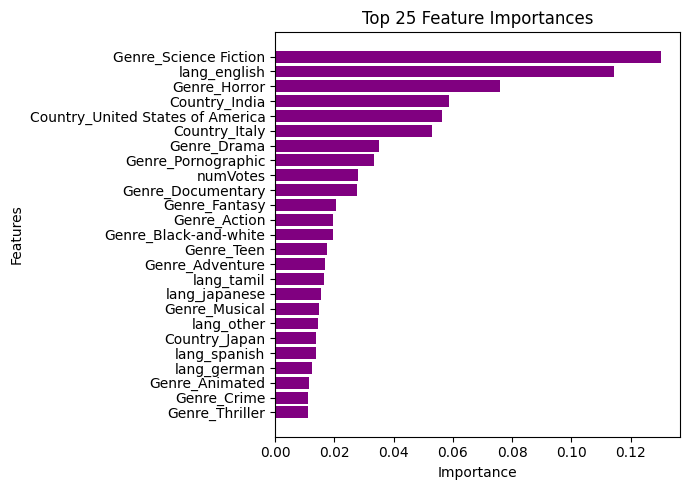

Analyzing period: 2000-2015

XGBRegressor RMSE:  0.8412735253271725
XGBRegressor R2:  0.4600601771045464
XGBRegressor Mean Absolute Error:  0.5977315404582825


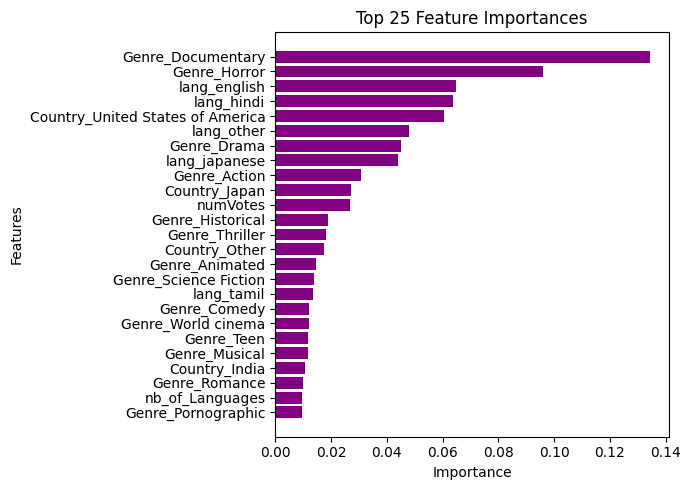

In [23]:
plot_importance_per_period(df_mod,xgb,'averageRating')

## 2. Box Office Revenue

### Models Training

In [24]:
# Drops rows with missing values in the 'Movie_box_office_revenue' column
df_mod_clean = df_mod.dropna(subset='Movie_box_office_revenue')

# Create a DataFrame with the minimum Consumer Price Index (CPI) value for each year
cpi = pd.read_csv("./data/CPI.csv")
cpi = pd.DataFrame(cpi.groupby('year').apply(lambda x: x['value'].min(),include_groups=False),columns=['cpi'])
base_cpi = cpi.loc[2015].values[0]

df_mod_cpi = df_mod_clean.merge(cpi,left_on='Year',right_on='year',how='left')

# Calculate the adjusted movie box office revenue by accounting for inflation
df_mod_cpi['Adjusted_Revenue'] = df_mod_cpi['Movie_box_office_revenue']*(base_cpi/df_mod_cpi['cpi'])
df_mod_cpi

,Movie_box_office_revenue,Year,Year_Interval,nb_of_Genres,Genre_Action,Genre_Adventure,Genre_Animated,Genre_Black-and-white,Genre_Bollywood,Genre_Chinese Movies,...,Country_India,Country_Italy,Country_Japan,Country_Other,Country_United Kingdom,Country_United States of America,averageRating,numVotes,cpi,Adjusted_Revenue
0,21502796.0,1992,1970-2000,12,True,True,True,False,False,False,...,False,False,False,False,False,True,7.4,197717.0,119.200,2.296181e+07
1,50000000.0,1915,1915-1930,7,False,False,False,True,False,False,...,False,False,False,False,False,True,6.1,26681.0,8.700,7.315402e+08
2,33139618.0,1982,1970-2000,12,False,False,False,False,False,True,...,False,False,False,False,False,True,8.1,835060.0,89.200,4.729009e+07
3,119500000.0,1974,1970-2000,3,False,False,False,False,False,False,...,False,False,False,False,False,True,7.7,155432.0,41.500,3.665281e+08
4,8551228.0,1986,1970-2000,3,False,False,False,False,False,False,...,False,False,False,False,False,True,7.7,219742.0,100.000,1.088469e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6905,1000000.0,1953,1950-1970,1,False,False,False,False,False,False,...,False,False,False,False,False,True,5.4,505.0,24.900,5.111968e+06
6906,1000000.0,1953,1950-1970,3,True,False,False,False,False,False,...,False,False,False,False,False,True,6.3,397.0,24.900,5.111968e+06
6907,1025000.0,1951,1950-1970,1,False,False,False,False,False,False,...,False,False,False,False,False,True,6.1,243.0,23.700,5.505072e+06
6908,33449086.0,2012,2000-2015,1,False,False,False,False,False,False,...,False,False,False,False,False,True,4.8,11049.0,124.128,3.430062e+07


In [25]:
df_mod_cpi['Adjusted_Revenue'].describe()

count    6.910000e+03
mean     6.916721e+07
std      1.593224e+08
min      1.269968e+04
25%      6.484692e+06
50%      1.921179e+07
75%      6.565012e+07
max      4.136860e+09
Name: Adjusted_Revenue, dtype: float64

array([[<Axes: title={'center': 'Adjusted_Revenue'}>]], dtype=object)

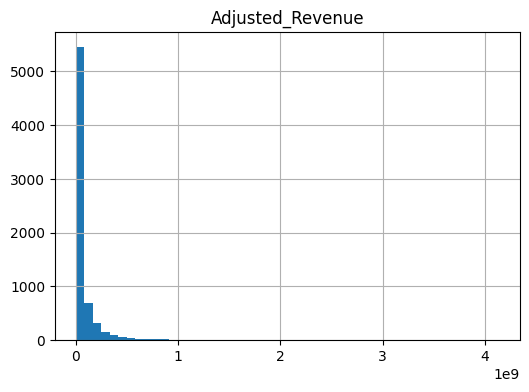

In [26]:
df_mod_cpi.hist(column='Adjusted_Revenue', bins=50, figsize=(6, 4))

In [27]:
df_mod_cpi[df_mod_cpi['Adjusted_Revenue'] > 5e8].shape

(144, 61)

In [28]:
df_mod_cpi.shape

(6910, 61)

Ouliers corresponds to 2% of the data, we will remove them from the dataset:

In [29]:
df_mod_cpi = df_mod_cpi[df_mod_cpi['Adjusted_Revenue'] < 5e8]

In [30]:
# Define features and target
X_rev = df_mod_cpi.drop(columns=['Movie_box_office_revenue','cpi','Adjusted_Revenue', 'Year_Interval'])
y_rev = df_mod_cpi['Adjusted_Revenue']

# Split data
X_train_rev, X_test_rev, y_train_rev, y_test_rev = train_test_split(X_rev, y_rev, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled_rev = scaler.fit_transform(X_train_rev)
X_test_scaled_rev = scaler.fit_transform(X_test_rev)

In [31]:
# Train a Linear regression model
lr_ = LinearRegression()
mse_lr_, r2_lr_ , _ = compute_MSE_R2score(lr_,X_train_scaled_rev,X_test_scaled_rev,y_train_rev,y_test_rev)

# Train a Ridge regression model
ridge_ = Ridge(alpha=1.0)
mse_ridge_, r2_ridge_, _ = compute_MSE_R2score(ridge_,X_train_scaled_rev,X_test_scaled_rev,y_train_rev,y_test_rev)

# Train a Random Forest model
rf_ = RandomForestRegressor(random_state=42)
mse_rf_, r2_rf_, _ = compute_MSE_R2score(rf_,X_train_rev,X_test_rev,y_train_rev,y_test_rev)

# Train an XGBoost model
xgb_ = XGBRegressor(random_state=42)
mse_xgb_, r2_xgb_, _ = compute_MSE_R2score(xgb_,X_train_rev,X_test_rev,y_train_rev,y_test_rev)

# Train a Bagging Regressor model
bag_ = BaggingRegressor(random_state=42)
mse_bag_, r2_bag_, _ = compute_MSE_R2score(bag_,X_train_rev,X_test_rev,y_train_rev,y_test_rev)

# Train a Gradient Boosting model
gb_ = GradientBoostingRegressor(n_estimators=100, random_state=42)
mse_gb_, r2_gb_, _ = compute_MSE_R2score(gb_,X_train_rev,X_test_rev,y_train_rev,y_test_rev)

# Train a Decision Tree model
dt_ = DecisionTreeRegressor(random_state=42)
mse_dt_, r2_dt_, _ = compute_MSE_R2score(dt_,X_train_rev,X_test_rev,y_train_rev,y_test_rev)


LinearRegression RMSE:  70089065.42558262
LinearRegression R2:  0.24918966219575311
LinearRegression Mean Absolute Error:  42023543.38425849

Ridge RMSE:  70087978.6082939
Ridge R2:  0.2492129464933598
Ridge Mean Absolute Error:  42024236.05122107

RandomForestRegressor RMSE:  51815791.515495375
RandomForestRegressor R2:  0.5896504336486115
RandomForestRegressor Mean Absolute Error:  30146599.81440948

XGBRegressor RMSE:  52773016.0207298
XGBRegressor R2:  0.5743491197302925
XGBRegressor Mean Absolute Error:  30983925.236790955

BaggingRegressor RMSE:  54043930.268774904
BaggingRegressor R2:  0.5536006480592846
BaggingRegressor Mean Absolute Error:  31583874.09032582

GradientBoostingRegressor RMSE:  52983616.47902042
GradientBoostingRegressor R2:  0.5709450642398123
GradientBoostingRegressor Mean Absolute Error:  30950248.967702497

DecisionTreeRegressor RMSE:  71177949.06364149
DecisionTreeRegressor R2:  0.22567969925733733
DecisionTreeRegressor Mean Absolute Error:  39280502.611218

### Comparison of Model Performance: Mean Squared Error and R-squared

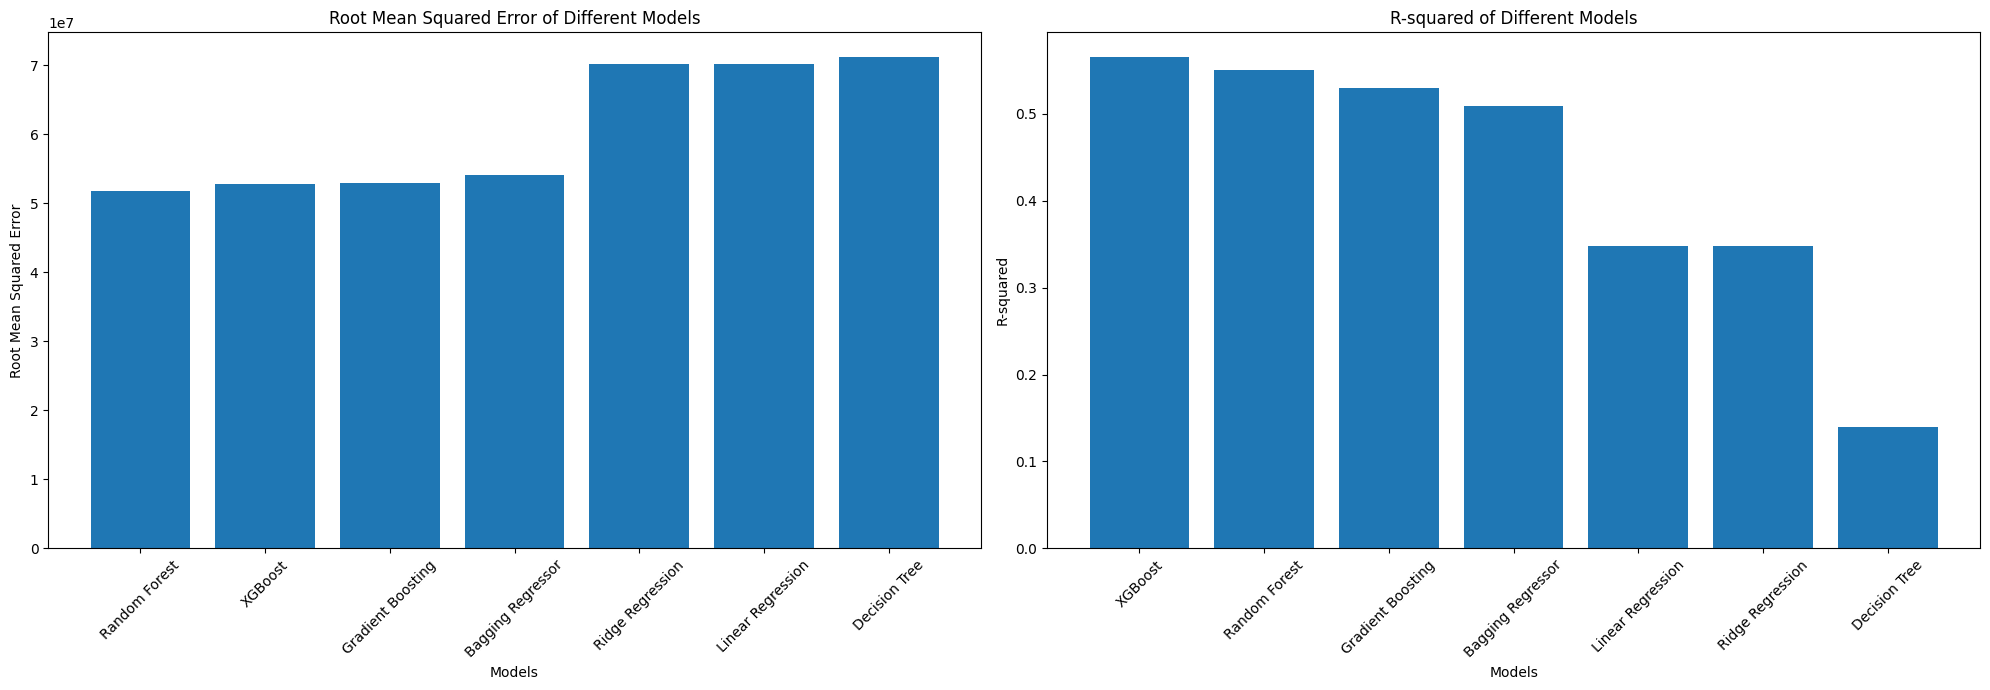

In [32]:
# Sorting the models 
errors_mse_ = [mse_lr_, mse_ridge_, mse_rf_, mse_xgb_, mse_bag_, mse_gb_, mse_dt_]
sorted_pairs_mse_ = sorted(zip(errors_mse_, models))
sorted_errors_mse_, sorted_models_ = zip(*sorted_pairs_mse_)

r2_scores_ = [r2_lr_, r2_ridge_, r2_rf_, r2_xgb_, r2_bag_, r2_gb_, r2_dt_]
sorted_pairs_r2_ = sorted(zip(r2_scores_, models), reverse=True)
sorted_r2_scores_, sorted_models_r2_ = zip(*sorted_pairs_r2)


fig, ax = plt.subplots(1, 2, figsize=(20, 7))

# Plotting the Root Mean Squared Error of different models
ax[0].bar(sorted_models_, sorted_errors_mse_)
ax[0].set_xlabel('Models')
ax[0].set_ylabel('Root Mean Squared Error')
ax[0].set_title('Root Mean Squared Error of Different Models')
ax[0].tick_params(axis='x', rotation=45)

# Plotting the R-squared of different models
ax[1].bar(sorted_models_r2_, sorted_r2_scores_)
ax[1].set_xlabel('Models')
ax[1].set_ylabel('R-squared')
ax[1].set_title('R-squared of Different Models')
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Taking in account the MSE and R-squared values, we can see that XGBoost has the best balance between prediction accuracy and model interpretability. Therefore, we will use this model to evaluate the importance and impact of each feature on the box office revenue.

### Feature Importance of the best model

#### A. Period 1915-2015

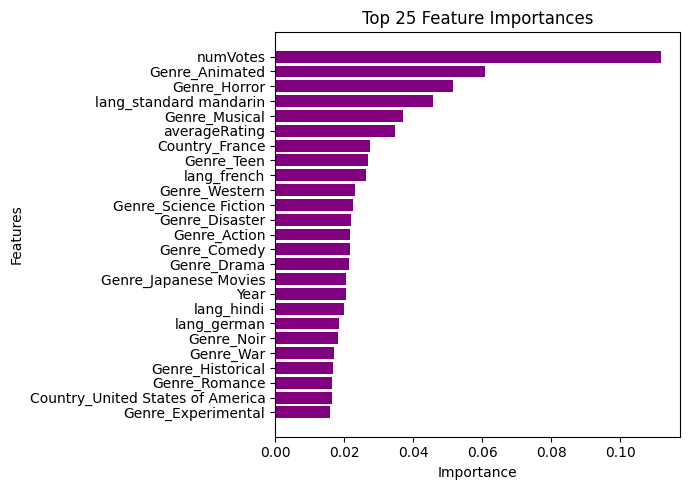

In [33]:
plot_feature_importance(xgb_,X_rev)

#### B. Period per Interval

Analyzing period: 1970-2000

XGBRegressor RMSE:  56991009.971046366
XGBRegressor R2:  0.5568156915845701
XGBRegressor Mean Absolute Error:  31802748.022220206


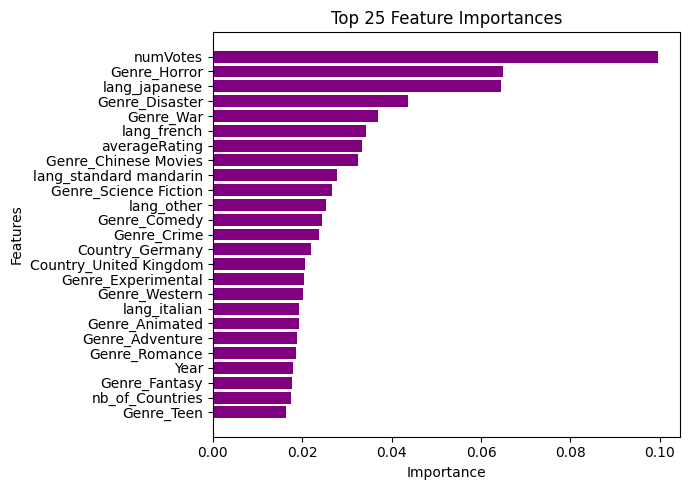

Analyzing period: 1930-1950

XGBRegressor RMSE:  19295112.798332572
XGBRegressor R2:  -0.14135539929267904
XGBRegressor Mean Absolute Error:  10737936.041489946


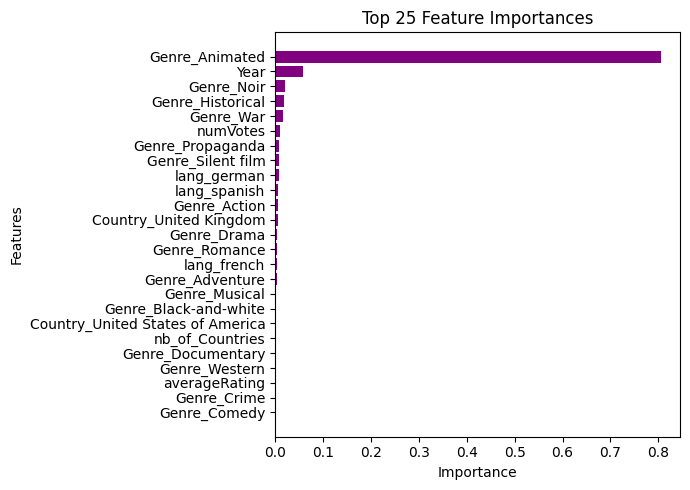

Analyzing period: 1950-1970

XGBRegressor RMSE:  48621113.421208255
XGBRegressor R2:  0.21214627453601054
XGBRegressor Mean Absolute Error:  24077734.315429777


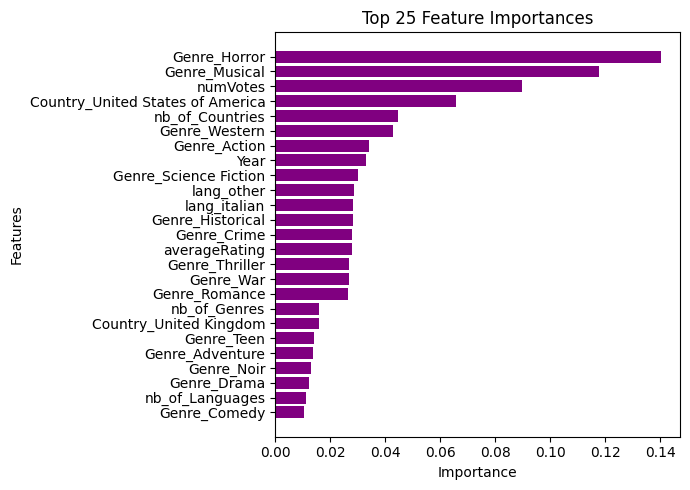

Analyzing period: 2000-2015

XGBRegressor RMSE:  54571902.61098906
XGBRegressor R2:  0.579779393949837
XGBRegressor Mean Absolute Error:  34623228.770364225


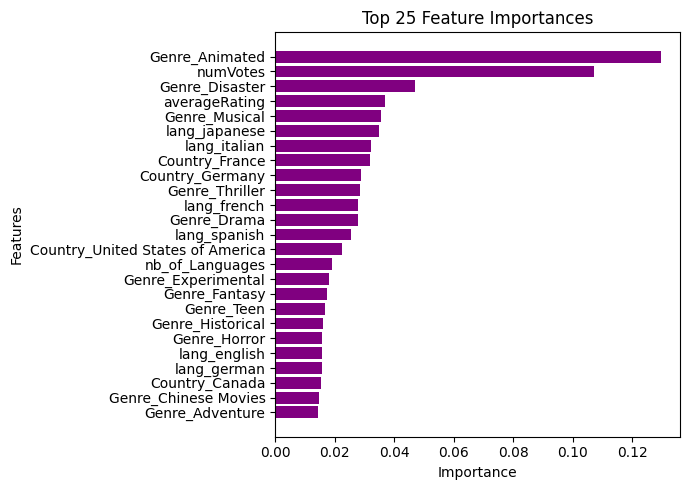

Analyzing period: 1915-1930

XGBRegressor RMSE:  24129253.94949237
XGBRegressor R2:  -0.46028197272929416
XGBRegressor Mean Absolute Error:  17555998.98308604


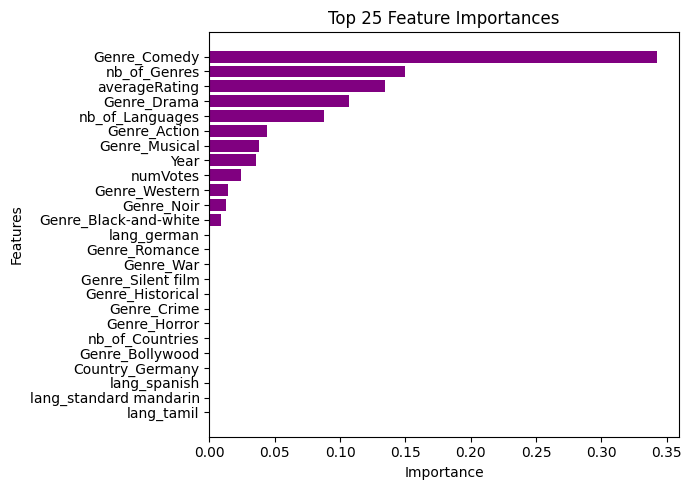

In [34]:
plot_importance_per_period(df_mod_cpi, xgb_, 'Adjusted_Revenue')